## Raster data operations
Raster data is an imporant format of spatial data. In this tutorial, we are going to using Python to manipulate the raster data format. We will work with `RasterIO` and `Numpy` for the raster data processing. RasterIO is a modern library to work with geospatial data in a gridded format. It excels at providing an easy way to read/write raster data and access individual bands and pixels as numpy arrays.

`RasterIO` is built on top of the popular `GDAL` (Geospatial Data Abstraction Library). GDAL is written in C++ so the Python API provided by GDAL is not very intuitive for Python users. RaserIO aims to make it easy for Python users to use the underlying GDAL library in an intuitive way.

In this section, we will clip a large remote sensing images into different clips and then merge them together.

By Xiaojiang Li, Temple University, Feb 13, 2021

### Prepare the Python modules

In [1]:
import os, os.path
import numpy as np
import rasterio as rio
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import get_data_window
from rasterio.windows import Window
from rasterio.merge import merge
# optional - turn off warnings
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

### Read the raster data and get the metadata of the raster data

After running the notebook of `naip-downloader.ipynb`, you will download the NAIP tiles for Philadelphia. Then we can check the data and explore how to use Python to do analyses on the raster data. If you have difficulty to download the NAIP tiles, I provide one for you to download. 

In [3]:
naip_file = 'cir-naip/nj_m_4007457_nw_18_1_20170824_20171102.tif'
naip_dataset = rio.open(naip_file)
naip_bounds = naip_dataset.bounds
naip_bounds

BoundingBox(left=499700.0, bottom=4434394.0, right=505631.0, top=4441934.0)

In [4]:
naip_dataset.crs

CRS.from_epsg(26918)

In [5]:
naip_dataset.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 5931,
 'height': 7540,
 'count': 4,
 'crs': CRS.from_epsg(26918),
 'transform': Affine(1.0, 0.0, 499700.0,
        0.0, -1.0, 4441934.0)}

### Now we can read the geotiff image for different bands

In [6]:
import numpy as np
from matplotlib import pyplot as plt

naip_file = 'cir-naip/pa_m_4007562_ne_18_1_20170910_20171207.tif'
naip_dataset = rio.open(naip_file)

# read the different bands of the raster data
green = np.float32(naip_dataset.read(3))
red = np.float32(naip_dataset.read(2))
nir = np.float32(naip_dataset.read(1))

# stack different layer images
cir = np.dstack((nir,red,green))


# plt.imshow(band1)
plt.figure(figsize=(15, 15), dpi=200)
plt.imshow(cir.astype(np.uint8))

### Display the NAIP image
Here is a function to resmaple the images for display. In some cases, we need to unsample raster data for visualization.

In [8]:
def display_naip_tile(filename, dsfactor = 2):
    """
    Display a NAIP tile using rasterio.
    
    dsfactor: downsample factor
    For .mrf-formatted tiles (which span multiple files), 'filename' should refer to the 
    .mrf file.
    """
    
    # NAIP tiles are enormous; downsize for plotting in this notebook
    
    with rasterio.open(filename) as raster:
        # rasterio uses 1-based indexing for channels.
        h = int(raster.height/dsfactor)
        w = int(raster.width/dsfactor)
        print('Resampling to {},{}'.format(h,w))
        ir = raster.read(1, out_shape=(1, h, w))
        r = raster.read(2, out_shape=(1, h, w))
        g = raster.read(3, out_shape=(1, h, w))
        
    cir = np.dstack((ir,r,g))
    fig = plt.figure(figsize=(7.5, 7.5), dpi=100, edgecolor='k')
    plt.imshow(cir)
    raster.close()
    

# naip_file = '../../data/naip-tiles/row0-col0.tif'
# display_naip_tile(naip_file)


### Calculate the NDVI from NAIP image

In [9]:
# here add 0.0000001 is to make sure the nir+red is not zero
ndvi = (nir - red)/(nir + red + 0.000001)

plt.figure(figsize=(15, 15))
plt.imshow(ndvi)

In [12]:
# check the statistics of the calcualted NDVI images
ndvi.max()

0.5210356

### Extract vegetation from NAIP image
Since vegetation usually has larger reflectance in the near infrared band than the red band, therefore, we can calculate the NDVI and use the NDVI to extract the vegetation part. 

In [10]:
plt.figure(figsize=(15, 15))

veg = np.zeros((ndvi.shape[0], ndvi.shape[1]), dtype = np.uint16)
veg[ndvi > 0] = 1

plt.imshow(veg)

<Figure size 1500x1500 with 0 Axes>

### Save raster data as a new tiff file
We can save our calculated vegetation cover map as a new geotiff file

In [14]:
out_tif = 'data/veg.tif'

# prepare the schema of the new tiles
out_meta = naip_dataset.meta.copy()

# update the schema of the ndvi image, because it is different from teh raw naip image, like only one band
out_meta.update({'count': 1,
                'dtype': 'uint16',
                 "height": ndvi.shape[0],
                 "width": ndvi.shape[1],
#                  "transform": out_transform,
                 "crs": naip_dataset.crs, 
                 'compress': 'lzw'}
               )

# this is required, because rio will use three dimension, even this is single band image
veg = veg.reshape(1, veg.shape[0], veg.shape[1])

with rio.open(out_tif, "w", **out_meta) as dest:
    dest.write(veg)
    

## Mapping the vegetation cover map for Philadelphia
We have downloaded the NAIP tiles for whole Philadelphia. We can use those tiles to create a vegetation map of whole Philadelphia. We need to mosaic those tiles to a large one and then mask out those pixels out of the Philadelphia admin boundary
### We are ready to generate the vegetation map for Philadelphia
However, one tile cannot cover the whole study area. Therefore, we need to mosaic and mask by admin boundary. There are serveral steps
1. Mosaic tiles into a large one
2. Mask the mosaiced tiles to the city
3. Chop the masked images into small tiles
4. Calculate the NDVI and create vegetation cover map


### Mosaic tiles into a large raster

In [8]:
# This function is used to mosaic geotiffs in the input folder
# Parameters:
#     dirpath: the folder name of the tif files
#     outfile: the output file of the mosaiced geotiff image

import rasterio
import ogr
import fiona
import os, os.path
from rasterio.merge import merge
import glob
from shapely.geometry import Polygon
from shapely.geometry import shape


# mosaicRasters(folder, os.path.join(root, 'naip-atlanta.tif'))
inputfolder= 'data/cir-naip'
outfile = 'data/mosacied-naip.tif'


# start to mosaic the raster tiles
tiflist = []

for file in os.listdir(inputfolder):    
    if file.endswith('.tif'):
        tiffile = os.path.join(inputfolder, file)
        tiflist.append(tiffile)


src_files_to_mosaic = []
for fp in tiflist:
    try:
        tile_src = rasterio.open(fp)
        tile_bounds = tile_src.bounds
        
        src_files_to_mosaic.append(tile_src)
    except:
        continue

print('The number of mosaiced tiles is:', len(src_files_to_mosaic))

# the method can be set as min, max..
mosaic, out_trans = merge(src_files_to_mosaic) #, method='max'
print('You have mosaiced the results')


# Prepare the schema of the output mosacied image
out_meta = tile_src.meta.copy()
out_meta.update({"driver": "GTiff",
                  "height": mosaic.shape[1],
                  "width": mosaic.shape[2],
                  "transform": out_trans, 
                  "compress": 'lzw',
                  'BIGTIFF': 'YES'
                  }
               )

#out_fp = os.path.join(dirpath, 'atlanta-naip.tif')
with rasterio.open(outfile, "w", **out_meta) as dest:
     dest.write(mosaic)


The number of mosaiced tiles is: 34
You have mosaiced the results


### Mask the mosaiced raster to Philadelphia
The mosaiced tiles cover regions outside of Philadelphia. We can use the city limit to maskout the pixels that outside of Phily.

In [9]:
import fiona

input_value_raster = 'data/mosacied-naip.tif'
shpfile = 'data/city_limit_proj.shp'
out_raster = 'data/maskPhily-naip.tif'


with fiona.open(shpfile, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(input_value_raster) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "compress": 'lzw',
                 "transform": out_transform})

with rasterio.open(out_raster, "w", **out_meta) as dest:
    dest.write(out_image)    


### Clip a large raster data into small tiles
You probably don't want to calculate the NDVI images based on the 4G NAIP image at once on your personal computer. We can chop the large raster data into smaller tiles, and then calculate the vegetation cover map.

In [6]:
lu_dataset = rasterio.open('data/maskPhily-naip.tif')
outfolder = 'data/naip-tiles'
if not os.path.exists(outfolder):
    os.mkdir(outfolder)


lu_img = lu_dataset.read()

# height and width of the raster
height, width = lu_dataset.shape

# split the large raser into number of tiles, tile size is 2000*2000
tile_width = 2000
tile_height = 2000

tile_num_col = int(width/tile_width) + 1
tile_num_row = int(height/tile_height) + 1

# the output folder
if not os.path.exists(outfolder): os.mkdir(outfolder)

# create each tile
for i in range(tile_num_row - 1):
    # loop each column
    for j in range(tile_num_col - 1):
        print('The i and j is:', i, j)
        tilename = os.path.join(outfolder, 'row%s-col%s.tif'%(i, j))
        
        row_start = i*tile_height
        col_start = j*tile_width
        row_end = (i + 1)*tile_height
        col_end = (j + 1)*tile_width
        
        # deal with the right boundary
        if row_end > height - 1: tile_height = height - row_start
        if col_end > width - 1: tile_width = width - col_start
        
        # window = get_data_window(lu_dataset.read(1, masked=True))
        window = Window(col_off=col_start, row_off=row_start, width=tile_width, height=tile_height)
        
        kwargs = lu_dataset.meta.copy()
        kwargs.update({
            'height': window.height,
            'width': window.width,
            'transform': rasterio.windows.transform(window, lu_dataset.transform)})
        
        with rasterio.open(tilename, 'w', **kwargs) as dst:
            dst.write(lu_dataset.read(window=window))

The i and j is: 0 0
The i and j is: 0 1
The i and j is: 0 2
The i and j is: 0 3
The i and j is: 0 4
The i and j is: 0 5
The i and j is: 0 6
The i and j is: 0 7
The i and j is: 0 8
The i and j is: 0 9
The i and j is: 0 10
The i and j is: 0 11
The i and j is: 0 12
The i and j is: 0 13
The i and j is: 0 14
The i and j is: 0 15
The i and j is: 0 16
The i and j is: 0 17
The i and j is: 0 18
The i and j is: 0 19
The i and j is: 0 20
The i and j is: 0 21
The i and j is: 0 22
The i and j is: 0 23
The i and j is: 0 24
The i and j is: 0 25
The i and j is: 0 26
The i and j is: 0 27
The i and j is: 0 28
The i and j is: 0 29
The i and j is: 0 30
The i and j is: 0 31
The i and j is: 0 32
The i and j is: 0 33
The i and j is: 0 34
The i and j is: 0 35
The i and j is: 0 36
The i and j is: 0 37
The i and j is: 0 38
The i and j is: 0 39
The i and j is: 0 40
The i and j is: 0 41
The i and j is: 0 42
The i and j is: 0 43
The i and j is: 0 44
The i and j is: 0 45
The i and j is: 0 46
The i and j is: 0 47
Th

KeyboardInterrupt: 

### Loop all the split tiles can compute the vegetation cover

In [24]:
out_tif = 'data/veg.tif'

infolder = 'data/naip-tiles'
outfolder = 'data/veg-tiles'

if not os.path.exists(outfolder):
    os.mkdir(outfolder)


for file in os.listdir(infolder):
    tiffile = os.path.join(infolder, file)
    
    # read the different bands of the raster data
    if not tiffile.endswith('.tif'): continue
    naip_dataset = rio.open(tiffile)
    green = np.float32(naip_dataset.read(3))
    red = np.float32(naip_dataset.read(2))
    nir = np.float32(naip_dataset.read(1))

    # here add 0.0000001 is to make sure the nir+red is not zero
    ndvi = (nir - red)/(nir + red + 0.000001)
    
    # extract the vegetation based on the ndvi
    veg = np.zeros((ndvi.shape[0], ndvi.shape[1]), dtype = np.uint16)
    veg[ndvi > 0] = 1
    
    
    # prepare the schema of the new tiles
    out_meta = naip_dataset.meta.copy()

    # update the schema of the ndvi image, because it is different from teh raw naip image, like only one band
    out_meta.update({'count': 1,
                    'dtype': 'uint16',
                     "height": ndvi.shape[0],
                     "width": ndvi.shape[1],
    #                  "transform": out_transform,
                     "crs": naip_dataset.crs, 
                     'compress': 'lzw'}
                   )
    
    
    # this is required, because rio will use three dimension, even this is single band image
    veg = veg.reshape(1, veg.shape[0], veg.shape[1])
    
    out_tif = os.path.join(outfolder, file)
    with rio.open(out_tif, "w", **out_meta) as dest:
        dest.write(veg)
    

In [52]:
lyr.crs
# naip_dataset.crs

{'init': 'epsg:26918'}

### Overlay shapefile on raster data

Zonal statistics of the raster data. Calculate the percentage of tree canopy cover in each census tract. 

https://www.earthdatascience.org/workshops/gis-open-source-python/crop-raster-data-in-python/

In [80]:
import fiona
import shapely
from shapely.geometry import shape
import rasterio
import rasterio.mask
import os, os.path
import numpy as np


inraster = 'data/maskPhily-naip.tif'
input_zone_polygon = 'data/philadelphia-census-tract-26918.shp'
output_shp_res = 'data/vegCoverCensus-tract.shp'


# Open the raster datasets
naip_dataset = rasterio.open(inraster)


# Prepare the polygon shapefile and then do the overlay of the raster data and the vector data
lyr = fiona.open(input_zone_polygon)
schema = lyr.schema
schema['properties']['ndvi'] = 'float'


with fiona.open(output_shp_res, 'w', driver = "ESRI Shapefile", crs = lyr.crs, schema=schema) as output:
    for idx, feat in enumerate(lyr):
        props = feat['properties']
        geom = feat['geometry']
        shape = [geom] # the rasterio need the list, therefore, create a list
        
        # mask the raster using the polygon
        outNAIP_image, out_transform = rasterio.mask.mask(naip_dataset, shape, 
                                                          nodata = 0,
                                                          crop=True)
        
        # calculate the ndvi from the clipped naip img, convert the int to float using numpy
        nir = np.float32(outNAIP_image[0, :, :])
        red = np.float32(outNAIP_image[1, :, :])
        ndvi = (nir - red)/(nir + red + 0.000001)
        
        # calculate the ndvi value
        mean_val = np.sum(ndvi)/np.count_nonzero(ndvi)
        
        # update the calculated ndvi value to the field
        props['ndvi'] = mean_val
        output.write({'properties': props,
                      'geometry': geom
                     })
        

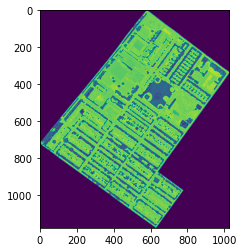

In [66]:
plt.imshow(nir - red)

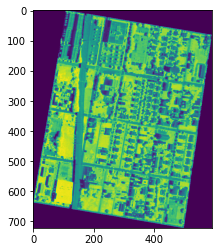

In [57]:
plt.imshow(outNAIP_image[0,:,:])

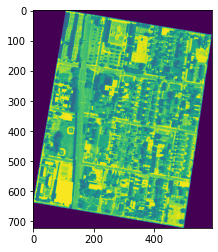

In [59]:
plt.imshow(outNAIP_image[2,:,:])

### Please select one city in US and generate the NDVI map and the vegetation cover map at the census tract level.

Put the your city name, and other info here, https://docs.google.com/spreadsheets/d/1yeHi_cMGrdnmGP5YLtz_QWb15IWiiYbCnzwtmwEH5hI/edit#gid=0

1. Collect the city limit file of the city. 
1. Download the NAIP tiles and mosaic them.
1. Mask out those pixel out of the bound.
1. Calculate the NDVI and vegetation cover map
1. Generate the census tract level map of NDVI and vegetation cover
